# SynFerm data preparation
#### Targets:
- Import data from db
- Filter invalid reactions
- Bin at a threshold
- Generate reactionSMILES for all reactions
- Export to CSV

In [61]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
from copy import deepcopy

from IPython.display import SVG, display
import sqlite3
import pandas as pd
import numpy as np
from rdkit.Chem import (
    Draw,
    rdChemReactions,
)

from definitions import DB_PATH
from src.db_retrieval.db_queries import MyDatabaseConnection
sys.path.insert(0, os.path.abspath('../../../rdkit-util'))
from reaction import create_reaction_instance, draw_chemical_reaction

In [2]:
db = MyDatabaseConnection()  # we will use this for various simple queries

In [3]:
con = sqlite3.connect(DB_PATH)
df_full = pd.read_sql('SELECT * FROM experiments', con, index_col='id', coerce_float=False ,parse_dates={'synthesis_date_unixepoch': {'utc': False, 'unit': 's'}})
con.close()
print(f'Number of reactions (in total): {len(df_full)}')

Number of reactions (in total): 26024


In [4]:
df_full = df_full.loc[df_full['exp_nr'].between(4, 100)]  # kick out invalid experiments (SOP changed after exp3)
print(f'Number of reactions since SOP change and without test reactions: {len(df_full)}')

Number of reactions since SOP change and without test reactions: 17280


In [5]:
df = df_full.loc[df_full['valid'].isna() 
                 | (df_full['valid'] == 'heating failure') 
                 | (df_full['valid'] == 'too many peaks for product A (2)') 
                 | (df_full['valid'] == 'too many peaks for product A (3)')
                 | (df_full['valid'] == 'too many peaks for product A (4)')
                ] 
print(f'Number of reactions after removing invalid entries: {len(df)}')

Number of reactions after removing invalid entries: 14147


In [6]:
df = df.loc[~df['product_A_lcms_ratio'].isna()]  # remove all entries where product A is NaN (these are the entries not yet measured)
print(f'Number of reactions after removing NaN entries: {len(df)}')

Number of reactions after removing NaN entries: 12227


Now we have a cleaned dataset. Let's bin it.

In [7]:
# first normalize all the lcms columns seperately
df = deepcopy(df)
lcms_df = df[['product_A_lcms_ratio', 'product_B_lcms_ratio', 'product_C_lcms_ratio', 'product_D_lcms_ratio', 'product_E_lcms_ratio', 'product_F_lcms_ratio', 'product_G_lcms_ratio', 'product_H_lcms_ratio']]
# df['A_normalized'] = (df['product_A_lcms_ratio']-df['product_A_lcms_ratio'].min())/(df['product_A_lcms_ratio'].max()-df['product_A_lcms_ratio'].min())
df[['A_normalized','B_normalized', 'C_normalized', 'D_normalized', 'E_normalized', 'F_normalized', 'G_normalized', 'H_normalized']] = (lcms_df-lcms_df.min())/(lcms_df.max()-lcms_df.min())
df                                      

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,vl_id,valid,A_normalized,B_normalized,C_normalized,D_normalized,E_normalized,F_normalized,G_normalized,H_normalized
id,,,,,,,,,,,,,,,,,,,,,
9618,5,2,A3,JG253,2021-08-16 22:00:00,I67,M2,T25,Ph023,Fused005,...,200310,heating failure,0.000227,0.000000,0.000335,0.000000,0.013379,0.00000,0.000000,0.000000
9619,5,2,A4,JG253,2021-08-16 22:00:00,I67,M2,T39,Ph023,Fused005,...,200324,heating failure,0.000000,0.000000,0.000000,0.000000,0.001412,0.00000,0.000041,0.000000
9620,5,2,A5,JG253,2021-08-16 22:00:00,I67,M2,T30,Ph023,Fused005,...,200315,heating failure,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
9621,5,2,A6,JG253,2021-08-16 22:00:00,I67,M2,T34,Ph023,Fused005,...,200319,heating failure,0.000000,0.000000,0.000000,0.000095,0.006787,0.00000,0.000000,0.000000
9622,5,2,A7,JG253,2021-08-16 22:00:00,I67,M2,T17,Ph023,Fused005,...,200302,heating failure,0.000429,0.000000,0.000000,0.000252,0.000662,0.00000,0.000000,0.000641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27596,11,6,P4,JG295,2022-01-24 23:00:00,I57,M67,T39,Ph007,Spiro009,...,172649,None,0.000000,0.001072,0.000000,0.023358,0.015007,0.00000,0.000000,0.000000
27597,11,6,P5,JG295,2022-01-24 23:00:00,I57,M67,T30,Ph007,Spiro009,...,172640,None,0.000332,0.000000,0.000000,0.032559,0.000000,0.00000,0.000000,0.000919
27598,11,6,P6,JG295,2022-01-24 23:00:00,I57,M67,T34,Ph007,Spiro009,...,172644,None,0.000896,0.000000,0.000000,0.072766,0.052386,0.00000,0.000181,0.000182


we introduce a "target" column, which is A_normalized binned at 0.01

In [8]:
df["target"] = pd.cut(df["A_normalized"], bins=[-1e-10, 0.01, 1.0000001], labels=[0, 1])
df

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,valid,A_normalized,B_normalized,C_normalized,D_normalized,E_normalized,F_normalized,G_normalized,H_normalized,target
id,,,,,,,,,,,,,,,,,,,,,
9618,5,2,A3,JG253,2021-08-16 22:00:00,I67,M2,T25,Ph023,Fused005,...,heating failure,0.000227,0.000000,0.000335,0.000000,0.013379,0.00000,0.000000,0.000000,0
9619,5,2,A4,JG253,2021-08-16 22:00:00,I67,M2,T39,Ph023,Fused005,...,heating failure,0.000000,0.000000,0.000000,0.000000,0.001412,0.00000,0.000041,0.000000,0
9620,5,2,A5,JG253,2021-08-16 22:00:00,I67,M2,T30,Ph023,Fused005,...,heating failure,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0
9621,5,2,A6,JG253,2021-08-16 22:00:00,I67,M2,T34,Ph023,Fused005,...,heating failure,0.000000,0.000000,0.000000,0.000095,0.006787,0.00000,0.000000,0.000000,0
9622,5,2,A7,JG253,2021-08-16 22:00:00,I67,M2,T17,Ph023,Fused005,...,heating failure,0.000429,0.000000,0.000000,0.000252,0.000662,0.00000,0.000000,0.000641,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27596,11,6,P4,JG295,2022-01-24 23:00:00,I57,M67,T39,Ph007,Spiro009,...,None,0.000000,0.001072,0.000000,0.023358,0.015007,0.00000,0.000000,0.000000,0
27597,11,6,P5,JG295,2022-01-24 23:00:00,I57,M67,T30,Ph007,Spiro009,...,None,0.000332,0.000000,0.000000,0.032559,0.000000,0.00000,0.000000,0.000919,0
27598,11,6,P6,JG295,2022-01-24 23:00:00,I57,M67,T34,Ph007,Spiro009,...,None,0.000896,0.000000,0.000000,0.072766,0.052386,0.00000,0.000181,0.000182,0


In [9]:
# add information about reactant classes to df
def get_reaction_type_for_series(ser):
    new = []
    for i in ser:
        new.append(db.get_reactant_class(i))
    return pd.Series(data=new)
        
df[['initiator_type', 'monomer_type', 'terminator_type']] = df[['initiator', 'monomer', 'terminator']].apply(get_reaction_type_for_series, axis=1)
df

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,C_normalized,D_normalized,E_normalized,F_normalized,G_normalized,H_normalized,target,initiator_type,monomer_type,terminator_type
id,,,,,,,,,,,,,,,,,,,,,
9618,5,2,A3,JG253,2021-08-16 22:00:00,I67,M2,T25,Ph023,Fused005,...,0.000335,0.000000,0.013379,0.00000,0.000000,0.000000,0,KAT_arom,Mon_fused,TerTH
9619,5,2,A4,JG253,2021-08-16 22:00:00,I67,M2,T39,Ph023,Fused005,...,0.000000,0.000000,0.001412,0.00000,0.000041,0.000000,0,KAT_arom,Mon_fused,TerTH
9620,5,2,A5,JG253,2021-08-16 22:00:00,I67,M2,T30,Ph023,Fused005,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0,KAT_arom,Mon_fused,TerTH
9621,5,2,A6,JG253,2021-08-16 22:00:00,I67,M2,T34,Ph023,Fused005,...,0.000000,0.000095,0.006787,0.00000,0.000000,0.000000,0,KAT_arom,Mon_fused,TerTH
9622,5,2,A7,JG253,2021-08-16 22:00:00,I67,M2,T17,Ph023,Fused005,...,0.000000,0.000252,0.000662,0.00000,0.000000,0.000641,0,KAT_arom,Mon_fused,TerABT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27596,11,6,P4,JG295,2022-01-24 23:00:00,I57,M67,T39,Ph007,Spiro009,...,0.000000,0.023358,0.015007,0.00000,0.000000,0.000000,0,KAT_arom,Mon_spiro_3,TerTH
27597,11,6,P5,JG295,2022-01-24 23:00:00,I57,M67,T30,Ph007,Spiro009,...,0.000000,0.032559,0.000000,0.00000,0.000000,0.000919,0,KAT_arom,Mon_spiro_3,TerTH
27598,11,6,P6,JG295,2022-01-24 23:00:00,I57,M67,T34,Ph007,Spiro009,...,0.000000,0.072766,0.052386,0.00000,0.000181,0.000182,0,KAT_arom,Mon_spiro_3,TerTH


We want to have the atom-mapped reactionSMILES as features. First, we need to grab the building block smiles from the database, then we enumerate the reactions

In [10]:
# grab the SMILES
df["initiator_SMILES"] = df["initiator"].apply(lambda x: db.get_smiles(x))
df["monomer_SMILES"] = df["monomer"].apply(lambda x: db.get_smiles(x))
df["terminator_SMILES"] = df["terminator"].apply(lambda x: db.get_smiles(x))

In [180]:
# For prototyping, I am good with having unmapped, plain reactionSMILES
def make_reaction_smiles(smiles):
    initiator, monomer, terminator, product = smiles
    return f"{initiator}.{monomer}.{terminator}>>{product}"


In [236]:

rxn_TH = rdChemReactions.ReactionFromSmarts(
        '[#9]-[#5-](-[#9])(-[#9])-[#6:2](-[*:1])=[#8:3].[#8]=[#6]-1-[#8]-C-2(-[#6]-[#6]-[#6]-[#6]-[#6]2)-[#8]-[#6:7]11-[#6:6]-[#6:5]-[#7:4]-[#8]-1.[#6:11]-[#6:10](=[#16:12])-[#7:9]-[#7:8]>>[#6:11]-[#6:10]:1:[#7:9]:[#7:8]:[#6:7](-[#6:6]-[#6:5]-[#7:4]-[#6:2](-[*:1])=[#8:3]):[#16:12]-1'
    )


rxn_ABT = rdChemReactions.ReactionFromSmarts(
    "[#9]-[#5-](-[#9])(-[#9])-[#6:2](-[*:1])=[#8:3].[#8]=[#6]-1-[#8]-C-2(-[#6]-[#6]-[#6]-[#6]-[#6]2)-[#8]-[#6:7]11-[#6:6]-[#6:5]-[#7:4]-[#8]-1.[#7:8]-[#6:9]1:[#6:10]:[#6:11]:[#6:12]:[#6:13]:[#6:14]:1-[#16:15]>>[*:1]-[#6:2](=[#8:3])-[#7:4]-[#6:5]-[#6:6]-[#6:7]1:[#7:8]:[#6:9]2:[#6:10]:[#6:11]:[#6:12]:[#6:13]:[#6:14]:2:[#16:15]:1"
)

In [237]:
# prepare for visualization
rdChemReactions.Compute2DCoordsForReaction(rxn_TH)
rdChemReactions.Compute2DCoordsForReaction(rxn_ABT)
# prepare for enumeration
rxn_TH.Initialize()
rxn_ABT.Initialize()
n_warn_TH, n_err_TH = rxn_TH.Validate(silent=True)
n_warn_ABT, n_err_ABT = rxn_ABT.Validate(silent=True)
if n_err_TH > 0:
    raise ValueError(f'Invalid reaction gave {n_err_TH} errors in validation')
if n_err_ABT > 0:
    raise ValueError(f'Invalid reaction gave {n_err_ABT} errors in validation')

In [276]:
def map_reactions(rxn, reactant_sets):
    """Take a reaction template and a list of reactant sets and return the mapped reactions."""
    mapped_reactions = []
    for i, reactant_set in enumerate(reactant_sets):
        reaction_inst = create_reaction_instance(rxn, reactant_set)
        if len(reaction_inst) == 1:  # all good
            mapped_reactions.append(reaction_inst[0])
        elif len(reaction_inst) == 0:  # failed
            mapped_reactions.append(None)
            print(f'ERROR: No product for reactant set with index {i}')
        else:  # too many resulting reactions
            # remove any duplicates
            idx = []
            unique_reactions = []
            for j, reac in enumerate(reaction_inst):
                reac_smarts = rdChemReactions.ReactionToSmarts(reac)
                if reac_smarts not in unique_reactions:
                    idx.append(j)
                    unique_reactions.append(reac_smarts)
                reaction_inst_cleaned = [reaction_inst[j] for j in idx]
                if len(reaction_inst_cleaned) > 1:
                    print(f'ERROR: Multiple products for reactant set with index {i}')

            mapped_reactions.append(reaction_inst_cleaned)
            
    return mapped_reactions
        

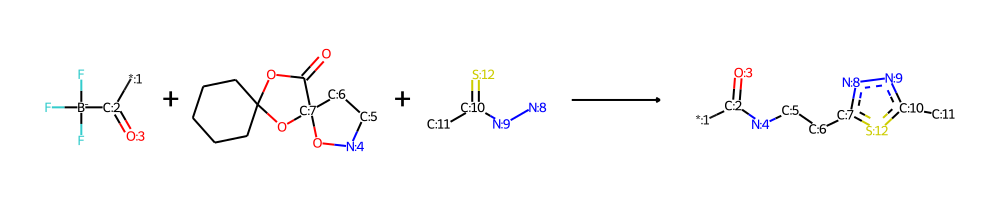

In [238]:
Draw.ReactionToImage(rxn_TH)

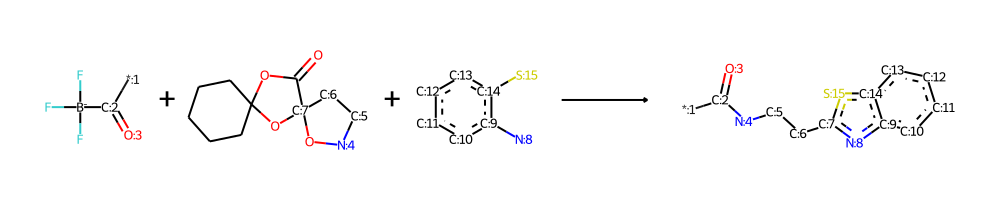

In [239]:
Draw.ReactionToImage(rxn_ABT)

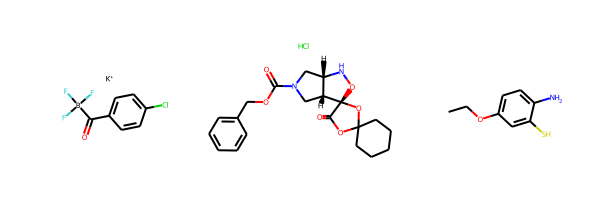

In [241]:
reactants = (MolFromSmiles(df.iat[4, -3]), MolFromSmiles(df.iat[4, -2]), MolFromSmiles(df.iat[4, -1]))
Draw.MolsToGridImage(reactants)

In [260]:
df["initiator_MOL"] = df["initiator_SMILES"].apply(MolFromSmiles)
df["monomer_MOL"] = df["monomer_SMILES"].apply(MolFromSmiles)
df["terminator_MOL"] = df["terminator_SMILES"].apply(MolFromSmiles)

In [ ]:
reactants_TH = df.loc[df["terminator_type"] == "TerTH", ["initiator_MOL", "monomer_MOL", "terminator_MOL"]].values.tolist()
indices_TH = df.loc[df["terminator_type"] == "TerTH"].index

In [287]:
reac_TH = map_reactions(rxn_TH, reactants_TH)
len(reac_TH)

In [291]:
for r in reac_TH:
    assert len(r) == 1

In [292]:
reaction_smiles_TH = [rdChemReactions.ReactionToSmiles(r[0]) for r in reac_TH]
df.loc[df["terminator_type"] == "TerTH", "reactionSMILES"] = reaction_smiles_TH

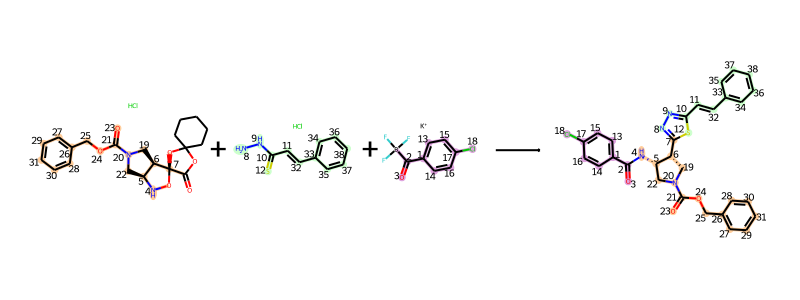

In [294]:
display(SVG(draw_chemical_reaction(df.iat[0,-1])))

In [295]:
reactants_ABT = df.loc[df["terminator_type"] == "TerABT", ["initiator_MOL", "monomer_MOL", "terminator_MOL"]].values.tolist()
indices_ABT = df.loc[df["terminator_type"] == "TerABT"].index

In [ ]:
reac_ABT = map_reactions(rxn_ABT, reactants_ABT)

In [ ]:
len(reac_ABT)

In [291]:
for r in reac_ABT:
    assert len(r) == 1

In [292]:
reaction_smiles_ABT = [rdChemReactions.ReactionToSmiles(r[0]) for r in reac_ABT]
df.loc[df["terminator_type"] == "TerABT", "reactionSMILES"] = reaction_smiles_ABT

In [62]:
df[["reactionSMILES", "target"]].to_csv("../../data/curated_data/SynFerm_reactionSMILES_unmapped_2022-02-18_prototype.csv", index=False)

In [80]:
# we also want to save subsets of data by experiment

for i in range(5, 12):
    df_mini = df.loc[df["exp_nr"].isin(range(4, i)), ["reactionSMILES", "target"]]
    print(f"exp4-{i-1}:")
    n_samples = len(df_mini)
    print(f"Number of samples: {n_samples}")
    print(f'Success rate: {df_mini["target"].astype("int").mean():.1%}')
    df_mini.to_csv(f"../../data/curated_data/SynFerm_reactionSMILES_unmapped_2022-02-18_prototype_exp4-{i-1}.csv", index=False)

exp4-4:
Number of samples: 1273
Success rate: 18.0%
exp4-5:
Number of samples: 3193
Success rate: 24.6%
exp4-6:
Number of samples: 4693
Success rate: 27.6%
exp4-7:
Number of samples: 6390
Success rate: 23.7%
exp4-8:
Number of samples: 8310
Success rate: 23.4%
exp4-9:
Number of samples: 9577
Success rate: 21.6%
exp4-10:
Number of samples: 10913
Success rate: 20.6%
